<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#quick-start" data-toc-modified-id="quick-start-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>quick start</a></span><ul class="toc-item"><li><span><a href="#Resources" data-toc-modified-id="Resources-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Resources</a></span></li></ul></li><li><span><a href="#FULL-MODEL" data-toc-modified-id="FULL-MODEL-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>FULL MODEL</a></span><ul class="toc-item"><li><span><a href="#Packages" data-toc-modified-id="Packages-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Packages</a></span><ul class="toc-item"><li><span><a href="#Qnetwork" data-toc-modified-id="Qnetwork-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Qnetwork</a></span></li></ul></li><li><span><a href="#POMDP-RNN-Game" data-toc-modified-id="POMDP-RNN-Game-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>POMDP RNN Game</a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Results</a></span><ul class="toc-item"><li><span><a href="#Standard-setting：-grid-=--(3,7)，-holes-=-0" data-toc-modified-id="Standard-setting：-grid-=--(3,7)，-holes-=-0-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>Standard setting： grid =  (3,7)， holes = 0</a></span></li><li><span><a href="#Model-Tranining" data-toc-modified-id="Model-Tranining-2.3.2"><span class="toc-item-num">2.3.2&nbsp;&nbsp;</span>Model Tranining</a></span></li><li><span><a href="#decoding-vs-performance" data-toc-modified-id="decoding-vs-performance-2.3.3"><span class="toc-item-num">2.3.3&nbsp;&nbsp;</span>decoding vs performance</a></span></li><li><span><a href="#learning-rate-vs-performance" data-toc-modified-id="learning-rate-vs-performance-2.3.4"><span class="toc-item-num">2.3.4&nbsp;&nbsp;</span>learning rate vs performance</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-2.3.5"><span class="toc-item-num">2.3.5&nbsp;&nbsp;</span>Summary</a></span></li><li><span><a href="#Anlytic-part-,-check-the-behaviour-correspond-to-each-decoding-level-and-explain-why" data-toc-modified-id="Anlytic-part-,-check-the-behaviour-correspond-to-each-decoding-level-and-explain-why-2.3.6"><span class="toc-item-num">2.3.6&nbsp;&nbsp;</span>Anlytic part , check the behaviour correspond to each decoding level and explain why</a></span></li></ul></li><li><span><a href="#PCA" data-toc-modified-id="PCA-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>PCA</a></span></li></ul></li></ul></div>

# quick start 

**Check relation betweeen dynamics and generalization.   Hypothesis to make: generalization can only be understood in level of joint dynamical system, there is a clear link between the two**

**Dynamnics determines generalization , not decoding , same decoding level can have very different dynamics , thus different generalization level.  Only when the dynamics of RNN forms object correspond to real relevant objects for game, the generalization can be good.   For instance , in a varying size game, you extend the size of game from 10 to 30, what will happen?  You can do a kind of dynamical programing , according to which wall you have seen and how many steps you have passed , you decide future action.    This can be achieved robustly by the dynamical system where fix points are correspond to walls**

## Resources

* [*The* Reinforcement learning book from Sutton & Barto](http://incompleteideas.net/sutton/book/the-book-2nd.html)
* [The REINFORCE paper from Ronald J. Williams (1992)](http://www-anw.cs.umass.edu/~barto/courses/cs687/williams92simple.pdf)


# FULL MODEL

## Packages

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from itertools import count
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
from torch.autograd import Variable
from torch.nn import init
from torch.nn import DataParallel
from torch.utils.data import DataLoader

import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib.animation
import seaborn as sns
from IPython.display import HTML

import pretrain
from pretrain import *

import navigation2
from navigation2 import *

import sklearn
from sklearn.svm import SVC
from sklearn.manifold import Isomap
from sklearn.manifold import SpectralEmbedding
from sklearn.manifold import TSNE
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import r2_score

import scipy
from scipy.spatial import distance
from scipy import signal

import dynamics
from dynamics import*

%pylab inline
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


/home/tie/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


For the liquid state approach to work, you need a lot of neurons as surplus or enough hidden to hidden connectivity to make it have an effect.

## PCA
differ by speed, stability and final results on different sizes of arena, both for intra, and extrapolation

In [2]:
class PretrainTest():
    def __init__(self, weight_write, holes = 0, inputs_type = (1, 0)):
        self.pregame = PretrainGame(grid_size = (15, 15), holes = holes, random_seed = 4 , set_reward = [(0.5, 0.25), (0.5, 0.75)], input_type = inputs_type[0])
        self.game = ValueMaxGame(grid_size = (15, 15), holes = 0, random_seed = 4 , set_reward = [(0.5, 0.25), (0.5, 0.75)], input_type = inputs_type[1])
        self.weight = weight_write
            
    def loadweight(self, weight_load):
#       need to take the state dict as a new dict for updating 
        net_dict = torch.load(weight_load)
        list_modules = [('h2h', net_dict['h2h']), ('a2h', net_dict['a2h']), ('i2h', net_dict['i2h']), ('r2h', net_dict['r2h']), ('bh', net_dict['bh'])]
        select_dict = OrderedDict(list_modules)
        net = self.pregame.net.state_dict()
        net.update(select_dict)
        self.pregame.net.load_state_dict(net)
        torch.save(self.pregame.net.state_dict(), self.weight) 
    
        
    def pretrain(self, trial, weight = None, lr = 1e-5, pretrain = True):  
        # start a pretrained game  
        self.pregame.net.cuda()
        if pretrain == True:
            lr = float(lr)
            if weight != None:
                self.pregame.net.load_state_dict(torch.load(weight))
            self.pregame.fulltrain(lr_rate = lr, trials = int(1e3), batchsize = 4)
        print ('pretrain end', torch.norm(self.pregame.net.h2h))
        if pretrain == True:
            torch.save(self.pregame.net.state_dict(), self.weight[:-1]+'{}'.format(trial))
        else:
            torch.save(self.pregame.net.state_dict(), self.weight+'{}'.format(trial))
        if pretrain == True and trial <= 10:
            self.weight = self.weight[:-1]+'{}'.format(trial)
        elif pretrain == True and trial > 10:
            self.weight = self.weight[:-2]+'{}'.format(trial)
        elif pretrain == False:
            self.weight = self.weight +'{}'.format(trial)
            
    def decode(self, weight = None):
        if weight != None:
            self.pregame.net.load_state_dict(torch.load(weight))
        else:
             self.pregame.net.load_state_dict(torch.load(self.weight))
        rls_q = RLS(1e2)
        rls_sl = RLS(1e2)
        self.game.net.cpu()
        self.game.experiment(rls_q, rls_sl,20, epsilon = 0.5, train_hidden = False, train_q = False, size_range=(15, 16), test = True) 
        def precision():
            prec0 = np.mean(decodetest(self.game, reward_control= 0, epsilon = 0)[0] + decodetest(self.game, reward_control = 1,  epsilon = 0)[0])
            prec1 = np.mean(decodetest(self.game, reward_control= 0, epsilon = 0.5)[0] + decodetest(self.game, reward_control =  1,  epsilon = 0.5)[0])
            prec2 = np.mean(decodetest(self.game, reward_control= 0, epsilon = 1)[0] + decodetest(self.game, reward_control =  1,  epsilon = 1)[0])
            return (prec0 + prec1 + prec2)/3, (prec2 - prec0)
        print ('decode train finish')
        Prec, dif = precision()
        print ('decode end', Prec, 'dif decode', dif)
        return Prec, dif
        # q learning session 
    
        
    def qlearn(self, weight_read, weight_write, iterations = 5, save = True, size_train = np.arange(10, 51, 10), \
               size_test = [10, 30], train_only = False, test_only = False, noise = 0.3, h2o = True,
              k_action = 1, k_internal = 1, k_stim = 1):
        self.game.net.load_state_dict(torch.load(weight_read))
        if h2o == True:
            self.game.net.h2o = nn.Parameter(torch.randn(512, 4) * 0.01 * np.sqrt(2.0/(512 + 4)))
        self.game.net.k_action = k_action
        self.game.net.k_internal = k_internal
        self.game.net.k_stim = k_stim
        e_rate = [noise for r in range(iterations)] 
        rls_q = RLS(1e2)
        rls_sl = RLS(1e2)
        Rewards = []
        # q leanring phase
        for n,e in enumerate(e_rate):
            prob = np.ones(len(size_train)) 
            prob = prob/np.sum(prob)
            if test_only == False:
                self.game.experiment(rls_q, rls_sl, iterations = 50, epochs= 10, epsilon = e, size_range = size_train)    
                if save == True:
                    torch.save(self.game.net.state_dict(), weight_write + '_{}'.format(n))
            def testing(game):
                Rewards00 = Test(game, reward_control = 0, size = size_test[0], test = 1)
                Rewards01 = Test(game, reward_control = 1, size = size_test[0], test = 1)
                rewards_s = (np.sum(Rewards00) + np.sum(Rewards01))/2
                Rewards10 = Test(game, reward_control = 0, size = size_test[1], test = 2)
                Rewards11 = Test(game, reward_control = 1, size = size_test[1], test = 2)
                rewards_l = (np.sum(Rewards10) + np.sum(Rewards11))/2
                return rewards_s, rewards_l
            # load weight if test only is true 
            if test_only == True:
                self.game.net.load_state_dict(torch.load(weight_write))
            if train_only == False:
                rewards_s, rewards_l = testing(self.game)
            print (n, 'rewards_s',  rewards_s, 'rewards_l', rewards_l)
            Rewards.append((rewards_s, rewards_l))
        return Rewards
    
    def TestAllSizes(self, size_range = np.arange(5, 50, 5), k_action = 1, k_internal = 1, 
                    k_stim = 1, limit_set = 4, test_size = 1):
        self.game.net.load_state_dict(torch.load(self.weight))
        self.game.net.cpu()
        self.Performance = []
        self.game.net.k_action = k_action
        self.game.net.k_internal = k_internal
        self.game.net.k_stim = k_stim
        for size in size_range:
            Rewards0 = Test(self.game, reward_control = 0, size = size, limit_set = limit_set, test = test_size)
            Rewards1 = Test(self.game, reward_control = 1, size = size, limit_set = limit_set, test = test_size)
            self.Performance.append((Rewards0 + Rewards1)/2)

1.0288283 1.3605248 -2.0522108


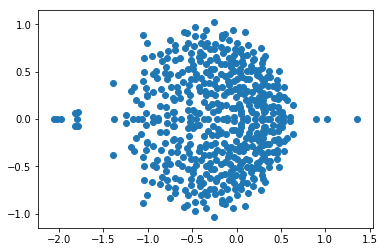

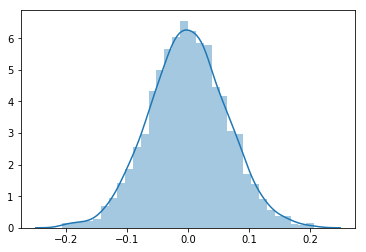

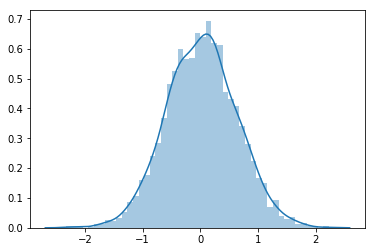

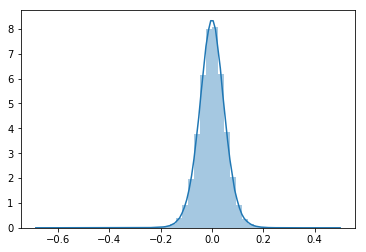

In [4]:
game = ValueMaxGame(grid_size = (15, 15), holes = 0, random_seed = 4 , set_reward = [(0.5, 0.25), (0.5, 0.75)],  alpha = 0.5, input_type = 0)
Net = torch.load('weights_pre2/rnn_1515tanh512_checkpoint49')
h2o = Net['h2o'].clone()
Weff = Net['h2h'] + h2o.matmul(Net['a2h'])
wreal = Weff.eig()[0][:,0].data.numpy().ravel() 
wimg = Weff.eig()[0][:,1].data.numpy().ravel()
print (np.max(np.abs(wimg)), np.max(wreal), np.min(wreal))
plt.scatter(Weff.eig()[0][:,0].data.numpy().ravel(), Weff.eig()[0][:,1].data.numpy().ravel())
plt.figure()
sns.distplot(Net['a2h'].data.numpy().ravel())
plt.figure()
sns.distplot(Net['i2h'].data.numpy().ravel())
plt.figure()
sns.distplot(Net['h2h'].data.numpy().ravel())

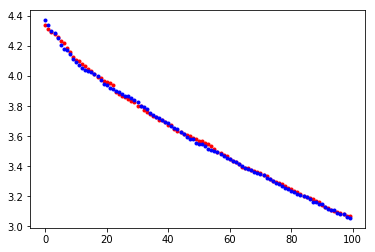

In [8]:
## The rank of pertubation 
Net = torch.load('weights_net1/rnn_1515tanh512_checkpoint39_0_9')
h2h_39 = Net['h2h'].clone()
Net = torch.load('weights_cpu1/rnn_1515tanh512_checkpoint0')
h2h_0 = Net['h2h'].clone()
dW = h2h_39 - h2h_0
dW = dW.data.numpy()
dW_shuffle = np.random.permutation(dW.ravel()).reshape(512, 512)
u, s, vh = np.linalg.svd(dW)
u_shuffle, s_shuffle, vh_shuffle = np.linalg.svd(dW_shuffle)
plt.figure()
plt.plot(s[:100],'r.')
plt.plot(s_shuffle[:100],'b.')

In [4]:
weight ='weights_net1_shuffle/rnn_1515tanh512_checkpoint39_2_9'
pca0 = PCA(weight = weight, size = 15)
pca0.pca()


pca1 = PCA(weight = weight, size = 50)
pca1.pca()



In [17]:
np.sum(pca0.vals) ** 2/np.sum(pca0.vals ** 2), np.sum(pca2.vals) ** 2/np.sum(pca2.vals ** 2), np.sum(pca4.vals) ** 2/np.sum(pca4.vals ** 2)

(12.924904981241399, 5.227789533539041, 7.6683081006280087)

In [16]:
weight ='weights_net1/weights2/rnn_1515tanh512_checkpoint0_0_9'
pca4 = PCA(weight = weight, size = 15)
pca4.pca()

In [7]:
for n in np.arange(1, 2, 1):
    weight ='weights_pre2/rnn_1515tanh512_checkpoint49'
    pca = PCA(weight = weight, size = 15)
    pca.pca(lowrank = np.arange(0, n, 1))

    print (np.sum(pca.vals) ** 2/np.sum(pca.vals ** 2))

2.9265144189113474


In [6]:
for n in np.arange(0, 4, 1):
    weight ='weights_cpu1/rnn_1515tanh512_checkpoint39_0_9'
    pca = PCA(weight = weight, size = 15)
    pca.pca(lowrank = [n])

    print (np.sum(pca.vals) ** 2/np.sum(pca.vals ** 2))

norm 9.064799
4.670239034749396
norm 5.949863
6.470963097691991
norm 5.493491
3.6586112972900566
norm 4.4421377
4.781239985561119


5.261464378353845
norm 10.843038
3.4193307858976962
norm 12.155242
5.3722094331030785
norm 12.941503
13.700818430935378


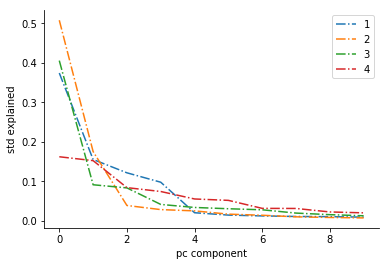

In [41]:
for n in np.arange(1, 5, 1):
    weight ='weights_cpu1/rnn_1515tanh512_checkpoint39_0_9'
    pca = PCA(weight = weight, size = 15)
    pca.pca(lowrank = np.arange(0, n, 1))
    print (np.sum(pca.vals) ** 2/np.sum(pca.vals ** 2))
#     plt.figure()
    ax = subplot(1, 1, 1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.plot(pca.vals[:10]/np.sum(pca.vals), '-.', label = n)

    plt.xlabel('pc component')
    plt.ylabel('std explained')
    plt.legend()


In [43]:
np.arange(0, 0, 1)

array([], dtype=int64)

2.2636007887812726
norm 7.7956195
4.342247039983342


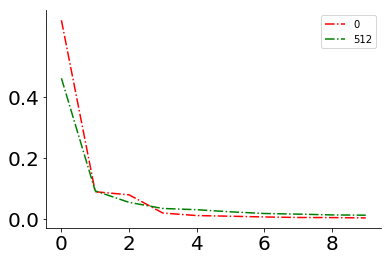

In [5]:
color = ['r', 'g', 'b','k']
for i, n in enumerate([0, 512]):
    weight ='weights_cpu1/rnn_1515tanh512_checkpoint300'
    pca = PCA(weight = weight, size = 15)
    pca.pca(lowrank = np.arange(0, n, 1))
    print (np.sum(pca.vals) ** 2/np.sum(pca.vals ** 2))
#     plt.figure()
    ax = subplot(1, 1, 1)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.plot(pca.vals[:10]/np.sum(pca.vals), '-.', label = n, color = color[i])
    plt.xticks(size = 20)
    plt.yticks([0, 0.2, 0.4], size = 20)
#     plt.xlabel('pc component')
#     plt.ylabel('std explained')
    plt.legend()
    
   

In [3]:
weight ='weights_cpu1/rnn_1515tanh512_checkpoint300'
pca = PCA(weight = weight, size = 15)
pca.pca(lowrank = np.arange(0, 512, 1))
torch.norm(pca.game.net.state_dict()['h2h'])

norm 7.7956195


tensor(32.0788)

In [6]:
dims = []
for i, n in enumerate(np.arange(10)):
    weight ='weights_cpu1/rnn_1515tanh512_checkpoint300'
    pca = PCA(weight = weight, size = 15)
    pca.pca(lowrank = np.arange(0, n, 1))
    dims.append(np.sum(pca.vals) ** 2/np.sum(pca.vals ** 2))


norm 2.9960418
norm 3.5372329
norm 3.8674495
norm 4.124839
norm 4.322775
norm 4.493528
norm 4.640137
norm 4.7659826


## GLM

In [10]:
def variance_decompose(pca, T, open_loop = True, alpha = 1e-4):
    Actions = np.zeros((pca.Hiddens.shape[0], pca.Hiddens.shape[1], T))
    Y = np.ones((pca.Hiddens.shape[0], pca.Hiddens.shape[1], T))
    X = np.ones((pca.Hiddens.shape[0], pca.Hiddens.shape[1], T))
    Stims = np.ones((pca.Hiddens.shape[0], pca.Hiddens.shape[1], T))
    colors = ['b', 'g', 'r', 'm']
    for i in range(pca.Hiddens.shape[0]):
        for j in range(pca.Hiddens.shape[1]):
            if open_loop == False:
                Actions[i, j] = pca.Actions[i, j, :T]
            else:
                Actions[i, j] = j
            Stims[i, j] = i
            Y[i, j] = pca.Ys[i, j, :T]
            X[i, j] = pca.Xs[i, j, :T]

    x =  pca.Hiddens[:, :, :T, :].reshape(-1, 512)
    z = (x - np.min(x))/(np.max(x) - np.min(x))
    y = np.log(z/(1-z + 1e-3) + 1e-3)
     ## features:
    A = np.array([np.eye(4)[int(a)] for a in Actions.reshape(-1)]).reshape(-1, 4)
    S = np.array([np.eye(4)[int(s)] for s in Stims.reshape(-1)]).reshape(-1, 4)
    Y = Y.reshape(-1, 1)/np.max(np.abs(Y))
    X = X.reshape(-1, 1)/np.max(np.abs(X))
    Features = np.concatenate((A, S, Y, X), axis = 1)
    Features_A = np.concatenate((S, Y, X), axis = 1)
    Features_S = np.concatenate((A, Y, X), axis = 1)
    Features_Y = np.concatenate((A, S, X), axis = 1)
    Features_X = np.concatenate((A, S, Y), axis = 1)

    clf1 = Lasso(alpha = alpha)
    clf1.fit(Features, y)
    y_pred = clf1.predict(Features)
    Importances = []
    importances = []
    for feature in [Features_A, Features_S, Features_Y, Features_X]:
        clf = Lasso(alpha= alpha)
        clf.fit(feature, y)
        y_pred_i = clf.predict(feature)
#         print (r2_score(y, y_pred_i), r2_score(y, y_pred))
        importances.append(r2_score(y, y_pred) - r2_score(y, y_pred_i))
        Importance = []
        for i in range(512):
            dif =  r2_score(y[:, i], y_pred[:, i]) - r2_score(y[:, i], y_pred_i[:, i])
            if dif<0:
                dif = 0
            Importance.append(dif)
        Importances.append(Importance)
    return importances

def Memory(weight, k_action = 1, k_stim = 1, k_internal = 1, lowrank = [], descend = True):
    Info_P = np.zeros(2)
    Info_I = np.zeros(2)
    Info_A = np.zeros(2)
    pca = PCA(weight = weight)
    if lowrank != []:
        pca.pca(T_duration = 3, lowrank = lowrank, descend = descend)
    else:
        pca.pca(T_duration = 3)
    pca.game.net.k_action = k_action
    pca.game.net.k_internal = k_internal
    pca.game.net.k_stim = k_stim
    pca.Dynamics(Actions = 50 * [0], legend = True, T_total = 200, T_stim = 100, T_duration = 3, \
                 readout_random = True, open_loop = False, e = 1)
    for i in range(2):
        T = 10 + i * 40
        importances = variance_decompose(pca, T, open_loop=False)
        Info_A[i] = importances[0]
        Info_I[i] = importances[1]
        Info_P[i] = importances[2] + importances[3]                        
    print (np.mean(Info_A), np.mean(Info_I), np.mean(Info_P))
    return Info_A, Info_I, Info_P 

0.00039519263966039664 0.4697043008248827 0.00018035577356140253
decay 1.4980867583646147
norm 5.2385874
h2h norm tensor(27.5425)
0.0006311073785968957 0.4705814488531141 0.0002484351365099058
decay 1.488757469609937
norm 7.126207
h2h norm tensor(27.6269)
norm 7.126207
0.0005312516576228068 0.23394604435058006 0.0003240111137630258
decay 0.1695670635563348
norm 8.399252
h2h norm tensor(27.7076)
norm 8.399252
0.0005125433456258724 0.22593514997635933 0.00041861499412751413
decay 0.17928841871348455
norm 9.471098
h2h norm tensor(27.6471)
norm 9.471098
0.0006767720441509389 0.2210612636916197 0.00032925537436005736
decay 0.413163294364889
norm 10.309963
h2h norm tensor(27.7525)
norm 10.309963
0.0004544768563869428 0.3530521392631936 0.000575481090400648
decay 0.8444291727270662
norm 11.006674
h2h norm tensor(27.7734)
norm 11.006674
0.000405878735404569 0.2223625055434745 0.0006286539308040656
decay 0.20670915909555848
norm 11.6398735
h2h norm tensor(27.8444)
norm 11.6398735
0.000741364107

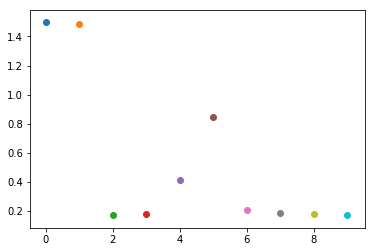

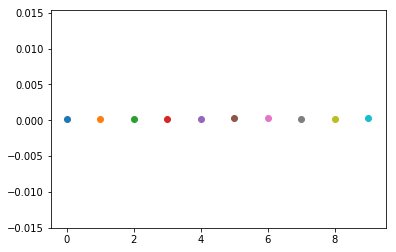

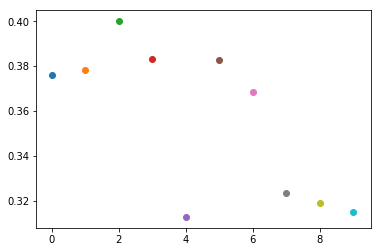

In [13]:
Info_Ps = []
Info_Is = []
Decay = []
Norms = []
for n in range(10):
    weight = 'weights_pre2/rnn_1515tanh512_checkpoint{}'.format(49)
    Info_A, Info_I, Info_P = Memory(weight, k_action = 1, k_stim = 1, k_internal = 1., lowrank = np.arange(0, n, 1))
    print ('decay', Info_I[-1]/Info_I[0])
    plt.figure(0)
    plt.scatter(n, Info_I[-1]/Info_I[0])
    Decay.append(Info_I[-1]/Info_I[0])
    plt.figure(1)
    plt.scatter(n, Info_P[0])
    Info_Ps.append(Info_P[0])
    plt.figure(2)
    plt.scatter(n, Info_I[0])
    Info_Is.append(Info_I[0])
    game = ValueMaxGame(grid_size = (15, 15), holes = 0, random_seed = 4 , set_reward = [(0.5, 0.25), (0.5, 0.75)], input_type = 0, action_control = 1, discount = 0.9, alpha = 1, time_limit=8,
                       lam = 0)
    game.net.load_state_dict(torch.load(weight))
    weight_lowrank(game.net, ranks = np.arange(0, (n+1), 1))
    print ('h2h norm', torch.norm(game.net.h2h))
    Norms.append( torch.norm(game.net.h2h))

([<matplotlib.axis.YTick at 0x7f6f4097f908>,
 <a list of 5 Text yticklabel objects>)

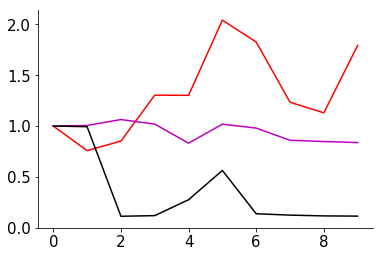

In [16]:
ax = subplot(1, 1, 1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.plot(Info_Ps[:10]/Info_Ps[0], 'r', label = 'path integration')
plt.plot(Info_Is[:10]/Info_Is[0], 'm', label = 'stimulus')
# plt.figure()
plt.plot(Decay[:10]/Decay[0], 'k', label = 'memory decay')
plt.xticks(size = 15)
plt.yticks([0, 0.5, 1, 1.5, 2], size = 15)
# plt.legend()

In [ ]:
for trial in [39]:
    print (trial)
    weight = 'weights_cpu1/rnn_1515tanh512_checkpoint{}'.format(trial)
  
    Info_A, Info_I, Info_P = Memory(weight, k_action = 4, k_stim = 1, k_internal = 1.2, lowrank = [0])
    print ('decay', Info_I[-1]/Info_I[0])

# Conclusion
**Internal dynamics rather than decoding performance influences more the performance in uncertain enviroments**

**Consider to think in global loops rather than separated system, thus the coupled dynamical system.  This system, which has its genome on its internal weights, will have quite different different pheno-types from the global loops,  richness of internal dynamics turns into extenable phenotypes which supports behaviours across scales.   The different types of attractors, fix point, limit cycle becomes substrate of strategy in different size rooms.  Thus generalization can be done until certain size, which offers complicate behaviour with a "simple mind"**

**The triangle between decoding, dynamics and navigation should be like: 1, dynamics coded by internal weight is most fundamental, it gives rise to different representations(phenotypes).   2,  The relation between decoding and navigation are reciprocal. not random behaviour gives better enviromental prediction(complement the free energy principle) 2,  we should distinguish internal dynamics and global dynamics**